In [13]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [14]:
points= np.array(np.load("points.npz")['data'])
means = np.mean(points, axis=1)
std_deviations = np.std(points, axis=1)

In [15]:
hist, bin_edges = np.histogram(points, bins=50, range=(-5, 5), density=True)

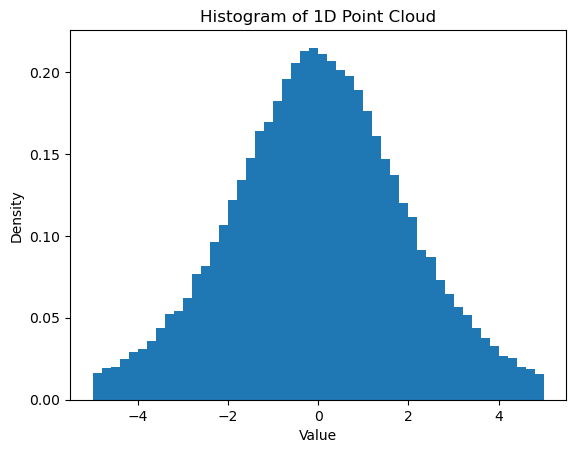

In [16]:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.bar(bin_centers, hist, width=0.2)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram of 1D Point Cloud")
plt.show()



In [17]:
# for simplicity we use our own basic implementation
# dataMat is assumed to be matrix of shape (nSamples,dimSample)
def PCA(dataMat,keep=None,centered=False):
    nSamples,dim=dataMat.shape
    # centerted True, then data is already centered
    if not centered:
        mean=np.mean(dataMat,axis=0)
        dataMat=dataMat.copy()
        dataMat=dataMat-mean
    if dim<nSamples:
        if keep is None:
            keep=dim
        A=dataMat.transpose().dot(dataMat)/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]
    else:
        if keep is None:
            keep=nSamples
        A=dataMat.dot(dataMat.transpose())/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]

        eigvec=np.einsum(eigvec,[0,1],dataMat,[1,2],[0,2])
        # renormalize
        normList=np.linalg.norm(eigvec,axis=1)
        eigvec=np.einsum(eigvec,[0,1],1/normList,[0],[0,1])
    if not centered:
        return mean,eigval,eigvec
    else:
        return eigval,eigvec



In [18]:
i = 0
hists = []
for point_array in points:
    hist, bin_edges = np.histogram(point_array, bins=50, range=(-5, 5), density=True)
    hists.append(hist)
hists = np.array(hists)

In [19]:
mean, eigval,eigvec = PCA(hists)
print(f"we got Means: {mean} \n some eigenvalues: {eigval} \n and some eigenvectors: {eigvec}")

we got Means: [0.0168743  0.01988474 0.02037011 0.02528187 0.02973925 0.03198085
 0.03658044 0.04445134 0.05332969 0.05513074 0.06302889 0.07740108
 0.08205621 0.09663931 0.10694518 0.12197594 0.13396959 0.14699926
 0.16354615 0.16846744 0.18109354 0.19407305 0.20400447 0.21102071
 0.21291426 0.20956661 0.20534854 0.19971927 0.1962885  0.1879978
 0.17499818 0.16019195 0.14652518 0.1367603  0.11979623 0.11172472
 0.09138269 0.0876915  0.07378211 0.06533    0.05741989 0.05254897
 0.04427946 0.0383191  0.03317361 0.02751874 0.02605355 0.02036747
 0.01933306 0.01612415] 
 some eigenvalues: [5.46229086e-02 4.31937912e-02 5.58296094e-03 3.24042694e-03
 1.73523506e-03 1.47889619e-03 1.38504570e-03 1.30526964e-03
 1.22843004e-03 1.20622523e-03 1.11233905e-03 1.04355662e-03
 9.70197497e-04 8.75359798e-04 7.70539413e-04 7.17251664e-04
 7.05737164e-04 6.77133506e-04 6.24260930e-04 5.65252035e-04
 5.19331341e-04 4.71265452e-04 4.50402650e-04 4.32936791e-04
 3.98438275e-04 3.53841096e-04 3.46026284

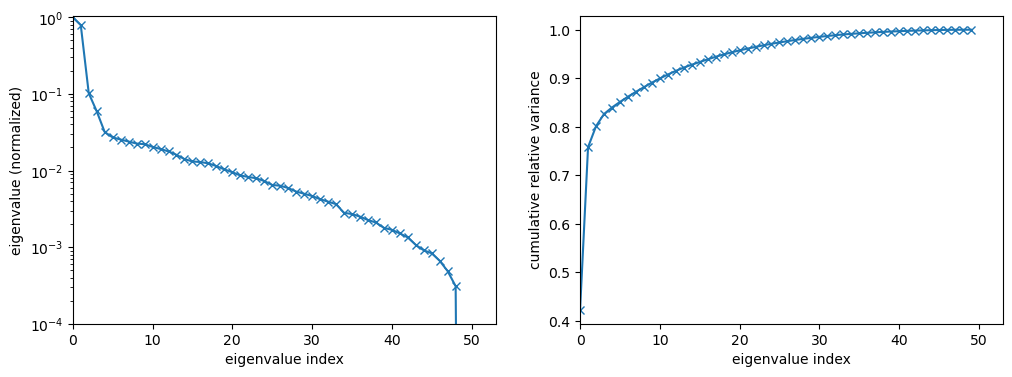

In [20]:
fig=plt.figure(figsize=(12,4))
axs=fig.subplots(1,2)

ax=axs[0]
ax.plot(eigval/eigval[0],marker="x")
ax.set_yscale("log")
ax.set_xlim([0,53])
ax.set_ylim([1E-4,1.05])
ax.set_xlabel("eigenvalue index")
ax.set_ylabel("eigenvalue (normalized)")

ax=axs[1]
cumdat=np.cumsum(eigval)
cumdat/=cumdat[-1]
ax.plot(cumdat,marker="x")
#ax.set_yscale("log")
ax.set_xlim([0,53])
#ax.set_ylim([1E-4,1.05])
ax.set_xlabel("eigenvalue index")
ax.set_ylabel("cumulative relative variance")


plt.show()

Just 2 components explain most of the data (80% of the variance)

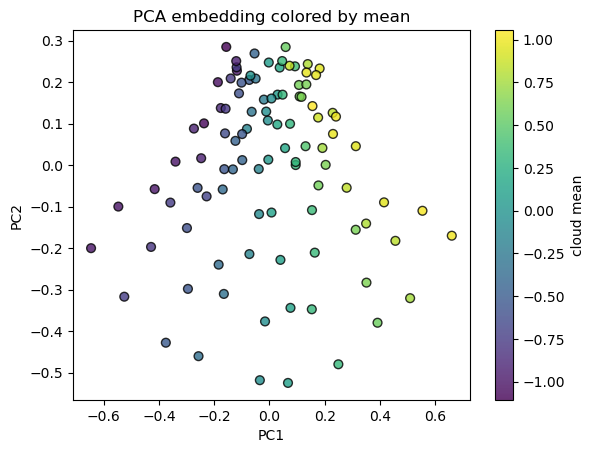

In [21]:
eigvals, eigvecs = PCA(hists, keep=2, centered=True)
data_centered=hists-mean

scores = data_centered @ eigvec.T         # (100,50) @ (50,2)  to (100,2)


plt.scatter(scores[:,0], scores[:,1],
            c=means, cmap='viridis', s=40, edgecolor='k', alpha=0.8)
plt.colorbar(label='cloud mean')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA embedding colored by mean')
plt.show()


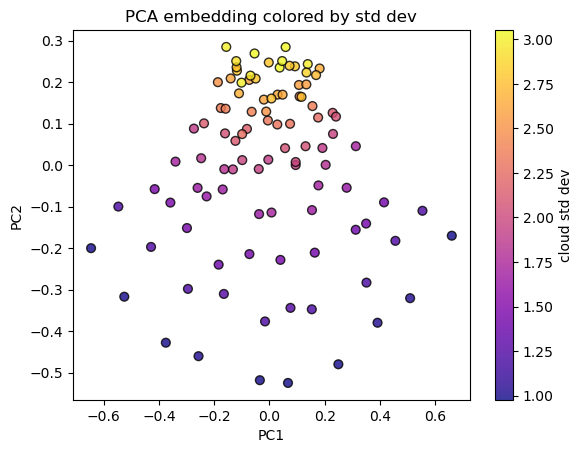

In [22]:
plt.scatter(scores[:,0], scores[:,1],
            c=std_deviations, cmap='plasma', s=40, edgecolor='k', alpha=0.8)
plt.colorbar(label='cloud std dev')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA embedding colored by std dev')
plt.show()


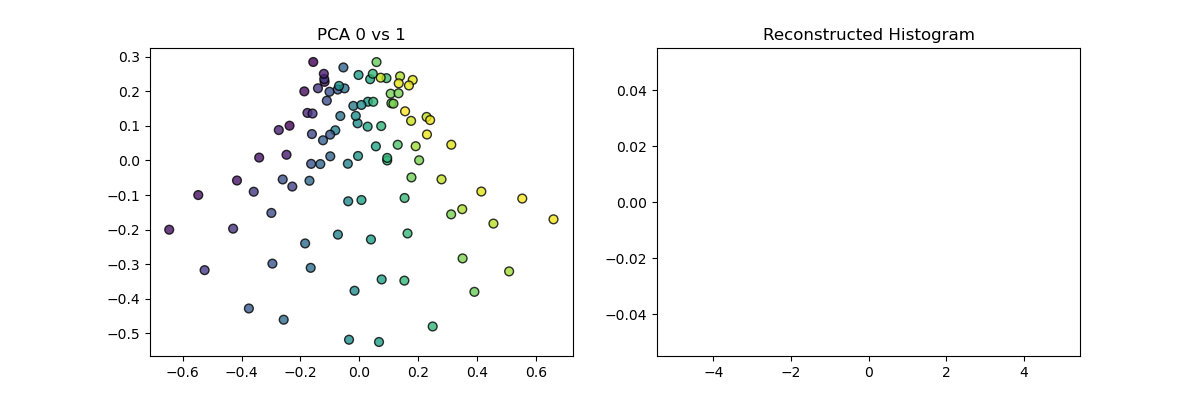

In [30]:
%matplotlib widget

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.set_title("PCA 0 vs 1")
ax0.scatter(scores[:,0], scores[:,1], c=means, cmap='viridis', s=40, edgecolor='k', alpha=0.8)

bar_container = ax1.bar(bin_centers, np.zeros_like(bin_centers), width=0.1)
ax1.set_title("Histogram")

def on_click(event):
    if event.inaxes is ax0:
        x, y = event.xdata, event.ydata
        idx = np.argmin((scores[:,0] - x)**2 + (scores[:,1] - y)**2)
        h_rec = mean + scores[idx,0]*eigvecs[0] + scores[idx,1]*eigvecs[1]
        for rect, h in zip(bar_container, h_rec):
            rect.set_height(h)
        ax1.relim()
        ax1.autoscale_view()
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()
